![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/Spark_NLP_Udemy_MOOC/Open_Source/28.01.TapasForQuestionAnswering.ipynb)

# **TapasForQuestionAnswering**

This video will cover how to use `TapasForQuestionAnswering`. `TapasForQuestionAnswering` annotator provides the ability to get answers to questions related to a table.

**📖 Learning Objectives:**

1. Set up `TapasForQuestionAnswering` pipeline

2. Prepare table and questions to use in `TapasForQuestionAnswering` 



**🔗 Helpful Links:**

- Documentation : [TapasForQuestionAnswering](https://nlp.johnsnowlabs.com/docs/en/annotators#TapasForQuestionAnswering)

- Python Docs : [TapasForQuestionAnswering](https://nlp.johnsnowlabs.com/api/python/reference/autosummary/sparknlp/annotator/classifier_dl/tapas_for_question_answering/index.html)

- Scala Docs : [TapasForQuestionAnswering](https://nlp.johnsnowlabs.com/api/com/johnsnowlabs/nlp/annotators/classifier/dl/TapasForQuestionAnswering.html)


## **📜 Background**


TAPAS (TAsk-based Pre-training for Adaptive Question Answering Systems) is a pre-training approach for question answering (QA) models. TAPAS was proposed by Google Research in a 2020 paper, "[TAPAS: Weakly Supervised Table-Based Question Answering.](https://arxiv.org/abs/2004.02349v2)". The TAPAS approach involves pre-training a transformer-based model on a large corpus of tables, where the model is trained to predict the answer to a question given the table and the question. 



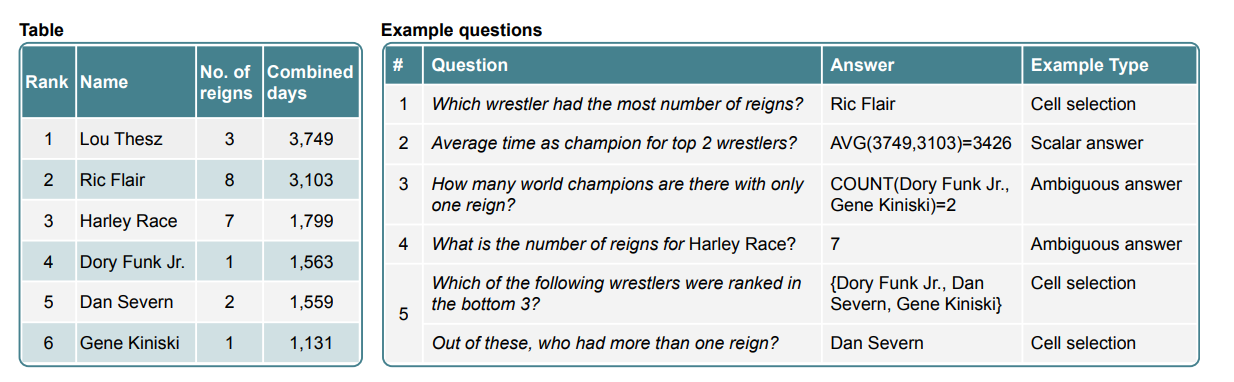

Our approach works on Spark Dataframes, which means that, if you have your tables in files, you need to load them first.

TAPAS is only available in `Spark NLP 4.2.0` and above. So please make sure you have upgraded to the latest Spark NLP release.

TAPAS models have been trained using a combination of three datasets:
- [SQA](https://www.microsoft.com/en-us/download/details.aspx?id=54253), Sequential Question Answering by Microsoft (it was not trained to return aggregation operations as SUM, COUNT, etc - see below)
- [WTQ](https://github.com/ppasupat/WikiTableQuestions), Wiki Table Questions by Stanford University (with aggregation operations)
- [WikiSQL](https://github.com/salesforce/WikiSQL), by Salesforce, also with aggregation operations.

As mentioned before, TAPAS models can return aggregation operation, if they are trained to do so:
-  All WTQ or WikiSQL models  returning those operations as part of the answer to the question if required. The operations are AVERAGE, SUM and COUNT.
- SQA models don't return any aggregation operation, just the answer in human language.

## **🎬 Colab Setup**

In [1]:
!pip install -q pyspark==3.3.1  spark-nlp==4.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.5/469.5 KB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 11.6 MB/s eta 0:00:00


In [4]:
import sparknlp
import pandas as pd

from sparknlp.annotator import TapasForQuestionAnswering, SentenceDetector
from sparknlp.base import MultiDocumentAssembler, TableAssembler
from pyspark.ml import Pipeline
from pyspark.sql import functions as F

spark = sparknlp.start()

## **🖨️ Input/Output Annotation Types**

- Input: `DOCUMENT`, `DOCUMENT`

- Output: `CHUNK`

## **🔎 Parameters**


- `maxSentenceLength`: (Int) Max sentence length to process (Default: 512).

- `batchSize`: (Int) Size of every batch (Default depends on model).

- `caseSensitive`: (BooleanParam) Whether to ignore case in index lookups (Default depends on model).

- `signatures`: (MapFeature[String, String]) It contains TF model signatures for the laded saved model.

- `vocabulary`: (MapFeature[String, String]) Vocabulary used to encode the words to ids with WordPieceEncoder.

## Example with pretrianed model

Let's create an example using the below table and some questions

| name         | money               | age |
|--------------|---------------------|-----|
| Donald Trump | \$100,000,000        | 75 |
| Elon Musk    | \$20,000,000,000,000 | 55 |

In [5]:
json_data = """
{
  "header": ["name", "money", "age"],
  "rows": [
    ["Donald Trump", "$100,000,000", "75"],
    ["Elon Musk", "$20,000,000,000,000", "55"]
  ]
}
"""

queries = [
    "Who earns less than 200,000,000?",
    "Who earns 100,000,000?", 
    "How much money has Donald Trump?",
    "How old are they?",
    "How much money have they total?",
    "Who earns more than Donald Trump?"
]

data = spark.createDataFrame([[json_data, " ".join(queries)]]).toDF("table_json", "questions")

TAPAS needs a specific annotator, called `MultiDocumentAssembler` to assemble the table and the questions together.

In [6]:
document_assembler = MultiDocumentAssembler() \
    .setInputCols("table_json", "questions") \
    .setOutputCols("document_table", "document_questions")

sentence_detector = SentenceDetector() \
    .setInputCols(["document_questions"]) \
    .setOutputCol("questions")



Then, we tell Spark NLP to manage `document_table` column as a table using a new annotator, `TableAssembler`

In [7]:
table_assembler = TableAssembler()\
    .setInputCols(["document_table"])\
    .setOutputCol("table")

Last component is `TapasForQuestionAnswering`, which will carry out the inference process

In [8]:
# WTQ TAPAS model
tapas_wtq = TapasForQuestionAnswering.pretrained("table_qa_tapas_base_finetuned_wtq", "en")\
    .setInputCols(["questions", "table"])\
    .setOutputCol("answers_wtq")

# SQA TAPAS model
tapas_sqa = TapasForQuestionAnswering\
    .pretrained("table_qa_tapas_base_finetuned_sqa","en")\
    .setInputCols(["questions", "table"])\
    .setOutputCol("answers_sqa")

table_qa_tapas_base_finetuned_wtq download started this may take some time.
Approximate size to download 394.7 MB
[OK!]
table_qa_tapas_base_finetuned_sqa download started this may take some time.
Approximate size to download 394.7 MB
[OK!]


Here is the complete pipeline 

In [9]:
#Define pipeline
pipeline = Pipeline(stages=[
    document_assembler,
    sentence_detector,
    table_assembler,
    tapas_wtq,
    tapas_sqa
])

# Fit and transform data
model = pipeline.fit(data)
result = model.transform(data)

In [10]:
result.printSchema()

root
 |-- table_json: string (nullable = true)
 |-- questions: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueContainsNull = true)
 |    |    |-- embeddings: array (nullable = true)
 |    |    |    |-- element: float (containsNull = false)
 |-- document_table: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueContai

In [11]:
result.show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Extract SQA results:

In [12]:
result.select(F.explode(result.answers_sqa)).show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|col                                                                                                                                                                                               |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|{chunk, 0, 12, Donald Trump, {question -> Who earns less than 200,000,000?, aggregation -> NONE, cell_positions -> [0, 0], cell_scores -> 0.9999999}, []}                                         |
|{chunk, 0, 12, Donald Trump, {question -> Who earns 100,000,000?, aggregation -> NONE, cell_positions -> [0, 0], cell_scores -> 0.9999999}, []}                                                   |
|{chunk, 0, 12,

Extract WTQ results:

In [13]:
result.select(F.explode(result.answers_wtq)).show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|col                                                                                                                                                                                     |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|{chunk, 0, 12, Donald Trump, {question -> Who earns less than 200,000,000?, aggregation -> NONE, cell_positions -> [0, 0], cell_scores -> 1.0}, []}                                     |
|{chunk, 0, 12, Donald Trump, {question -> Who earns 100,000,000?, aggregation -> NONE, cell_positions -> [0, 0], cell_scores -> 1.0}, []}                                               |
|{chunk, 0, 17, SUM($100,000,000), {question -> How much money ha

In [14]:
result.select(F.explode(F.arrays_zip(result.questions.result, result.answers_sqa.result, result.answers_wtq.result)).alias("cols"))\
      .select(F.expr("cols['0']").alias("question"), 
              F.expr("cols['1']").alias("answer_sqa"),
              F.expr("cols['2']").alias("answer_wtq")).show(truncate=False)

+---------------------------------+---------------------------------+--------------------------------------+
|question                         |answer_sqa                       |answer_wtq                            |
+---------------------------------+---------------------------------+--------------------------------------+
|Who earns less than 200,000,000? |Donald Trump                     |Donald Trump                          |
|Who earns 100,000,000?           |Donald Trump                     |Donald Trump                          |
|How much money has Donald Trump? |$100,000,000                     |SUM($100,000,000)                     |
|How old are they?                |75, 55                           |AVERAGE(75, 55)                       |
|How much money have they total?  |$100,000,000, $20,000,000,000,000|SUM($100,000,000, $20,000,000,000,000)|
|Who earns more than Donald Trump?|Elon Musk                        |Elon Musk                             |
+------------------

| name         | money               | age |
|--------------|---------------------|-----|
| Donald Trump | \$100,000,000        | 75 |
| Elon Musk    | \$20,000,000,000,000 | 55 |

As seen above `table_qa_tapas_base_finetuned_wtq` can provide answers with aggregation while `table_qa_tapas_base_finetuned_sqa` not.

You can find more pretrained TAPAS models on [Models Hub Page](https://nlp.johnsnowlabs.com/models?q=tapas).

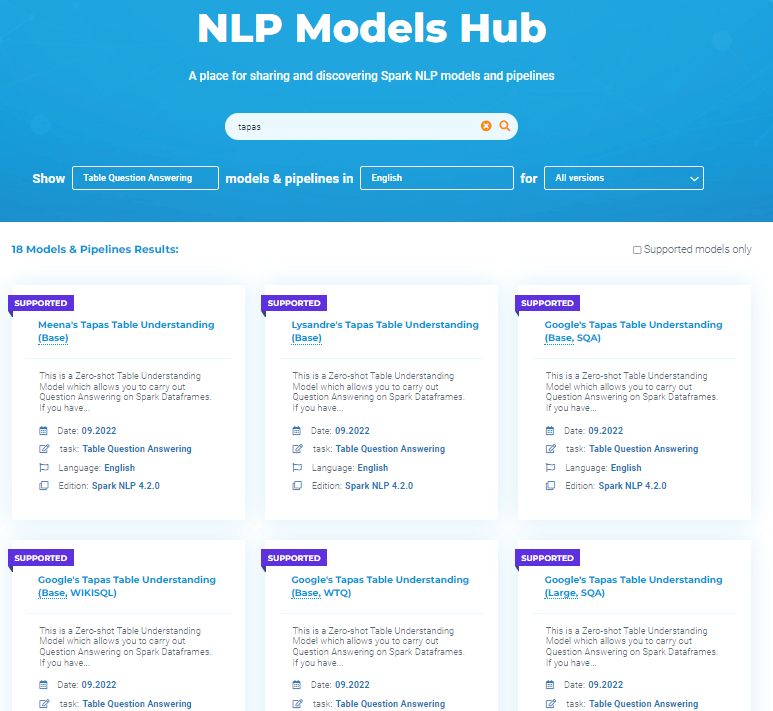